# Library

**Import Library**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

In [ ]:
pip install GPUTil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUTil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=88fb1d5c0f318159ac984addc0622f50c45c298db11efc147b9fa2bd047b00d7
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUTil


# Pre-Procesing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/DataSet_Revisi_Sidang'
dir_healthy = os.path.join(train_dir, 'Healthy')
dir_common_rust = os.path.join(train_dir, 'Common_Rust')
dir_gray_leaf_spot = os.path.join(train_dir, 'Gray_Leaf_Spot')
dir_blight = os.path.join(train_dir, 'Blight')

print(f"There are {len(os.listdir(dir_healthy))} images of Healthy.")
print(f"There are {len(os.listdir(dir_common_rust))} images of Common Rust.")
print(f"There are {len(os.listdir(dir_gray_leaf_spot))} images of Gray Leaf Spot.")
print(f"There are {len(os.listdir(dir_blight))} images of Blight.")

There are 1162 images of Healthy.
There are 1321 images of Common Rust.
There are 1154 images of Gray Leaf Spot.
There are 1146 images of Blight.


**Pembagian Data**

In [ ]:
# Path dataset
dataset_path = '/content/drive/MyDrive/DataSet_Revisi_Sidang'

# Membaca nama kelas
class_names = os.listdir(dataset_path)
images = []
labels = []

# Baca dataset
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if not a directory
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        images.append(img_path)
        labels.append(class_name)

# Verifikasi jumlah gambar yang ditemukan
print(f"Jumlah gambar yang ditemukan: {len(images)}")

# Lanjutkan jika ada gambar yang ditemukan
if len(images) == 0:
    raise ValueError("Tidak ada gambar yang ditemukan di dalam dataset. Periksa struktur direktori dan jalur dataset.")

# Ubah labels menjadi bentuk numerik
label_to_index = {name: index for index, name in enumerate(class_names)}
labels = np.array([label_to_index[label] for label in labels])

# Bagi dataset menjadi training dan testing
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Bagi training set menjadi training dan validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Fungsi untuk menyalin file ke direktori baru sesuai dengan set yang diberikan
def copy_files(image_paths, labels, target_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(target_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        new_img_path = os.path.join(label_dir, os.path.basename(img_path))
        shutil.copy2(img_path, new_img_path)

# Direktori sementara untuk set pelatihan, validasi, dan pengujian
base_dir = '/content/drive/MyDrive/DataSet_Split_epoach40'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Salin file ke direktori baru
copy_files(train_images, train_labels, train_dir)
copy_files(val_images, val_labels, val_dir)
copy_files(test_images, test_labels, test_dir)

# Augmentasi dan normalisasi data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='reflect'
)

# Normalisasi untuk validasi dan pengujian
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Print informasi tentang set pelatihan
print("Membuat generator untuk set pelatihan:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Print informasi tentang set validasi
print("Membuat generator untuk set validasi:")
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Print informasi tentang set pengujian
print("Membuat generator untuk set pengujian:")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Jumlah gambar yang ditemukan: 4783


KeyboardInterrupt: 

**Cek Batch**

In [ ]:
for x, y in train_generator:
    print(x.shape, y.shape)  # Cetak bentuk batch input dan label
    break  # Hanya perlu melihat satu batch

for x, y in validation_generator:
    print(x.shape, y.shape)  # Cetak bentuk batch input dan label
    break  # Hanya perlu melihat satu batch

(32, 224, 224, 3) (32, 4)
(32, 224, 224, 3) (32, 4)


**Cek Images Perlabel**

In [ ]:
# Definisikan path ke dataset
dataset_path = '/content/drive/MyDrive/DataSet_Revisi_Sidang'

# Tentukan jumlah gambar yang ingin ditampilkan per kelas
num_images_per_class = 5

def display_images(dataset_path, num_images_per_class):
    class_names = os.listdir(dataset_path)
    num_classes = len(class_names)

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class*3, num_classes*3))
    fig.suptitle('Contoh Gambar dari Setiap Kelas', fontsize=16)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)[:num_images_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = mpimg.imread(img_path)

            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')

            if j == 0:
                ax.set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_images(dataset_path, num_images_per_class)


Output hidden; open in https://colab.research.google.com to view.

# Model Densnet 201

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan jumlah kelas
num_classes = 4

# Muat model DenseNet201 dengan bobot pre-train dari ImageNet dan tanpa lapisan teratas
base_model = DenseNet201(weights='imagenet', include_top=False)

# Tambahkan lapisan global average pooling dan lapisan Dense sebagai classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

# Bekukan lapisan dasar model karna udh di latih di awal dengan imagenet
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model disini saya ujicoba learning Rate 0.0001
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Kutambahin callback
checkpoint_path = "model_checkpoint.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Hanya simpan yang terbaik
    monitor='val_accuracy',  # Monitor akurasi validasi
    mode='max',  # Mode maksimum, karena kita ingin akurasi yang maksimum
    verbose=1  # Cetak informasi ketika model diperbarui
)

# Mulai pelatihan #epoach 20 uji coba
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Pastikan steps per epoch sesuai
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Pastikan validation steps sesuai
    callbacks=[model_checkpoint_callback]  # Tambahkan di sini
)

# Memuat model terbaik
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_path)

Epoch 1/20
95/95 [==============================] - ETA: 0s - loss: 1.2565 - accuracy: 0.4313
Epoch 1: val_accuracy improved from -inf to 0.66576, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 1096s 11s/step - loss: 1.2565 - accuracy: 0.4313 - val_loss: 0.9708 - val_accuracy: 0.6658
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.7394
Epoch 2: val_accuracy improved from 0.66576 to 0.78261, saving model to model_checkpoint.h5
95/95 [==============================] - 1150s 12s/step - loss: 0.8348 - accuracy: 0.7394 - val_loss: 0.6947 - val_accuracy: 0.7826
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.8124
Epoch 3: val_accuracy improved from 0.78261 to 0.81522, saving model to model_checkpoint.h5
95/95 [==============================] - 1187s 13s/step - loss: 0.6384 - accuracy: 0.8124 - val_loss: 0.5524 - val_accuracy: 0.8152
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.8336
Epoch 4: val_accuracy improved from 0.81522 to 0.85462, saving model to model_checkpoint.h5
95/95 [==============================] - 1151s

**Cek Model Summary**

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, None, None, 3)        0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']    

**Graph Akurasi Model**

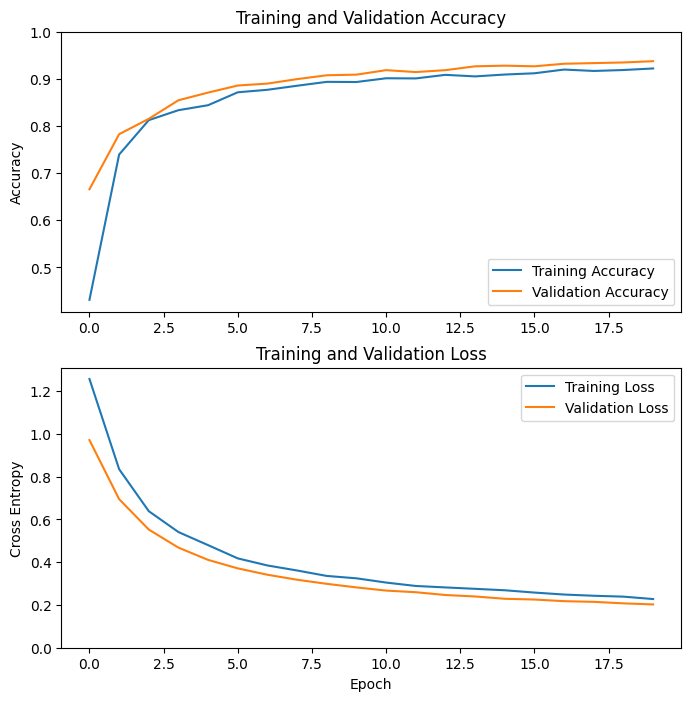

In [ ]:
import matplotlib.pyplot as plt

# Mengambil data akurasi dan loss dari history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot untuk akurasi
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Membuat plot untuk loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Menampilkan plot
plt.show()


# Evaluasi Model

Found 957 images belonging to 4 classes.
30/30 [==============================] - 282s 9s/step


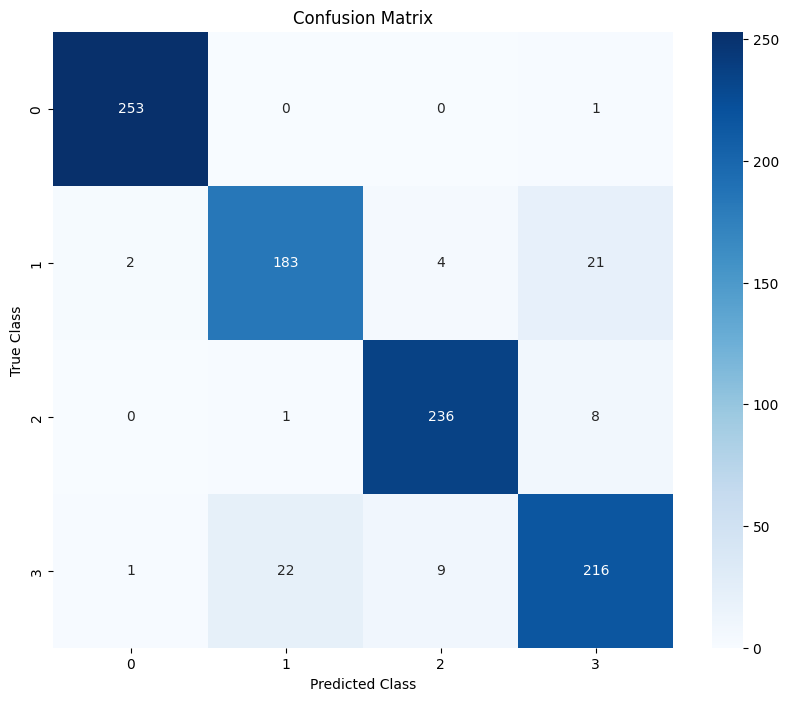

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       254
           1       0.89      0.87      0.88       210
           2       0.95      0.96      0.96       245
           3       0.88      0.87      0.87       248

    accuracy                           0.93       957
   macro avg       0.93      0.93      0.93       957
weighted avg       0.93      0.93      0.93       957



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the best model
best_model = load_model('model_checkpoint.h5')

# Data generator untuk testing (hanya rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path dataset
dataset_path = '/content/drive/MyDrive/DataSet_Split_epoach40'

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),  # Path ke direktori data uji
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# Membuat prediksi pada data uji
predictions = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan label sebenarnya dari test_generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Memplot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Menampilkan classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Testing manual model

Saving Corn_Gray_Spot (161).JPG to Corn_Gray_Spot (161).JPG
1/1 [==============================] - 4s 4s/step
Predicted class for Corn_Gray_Spot (161).JPG: Gray Leaft Spot


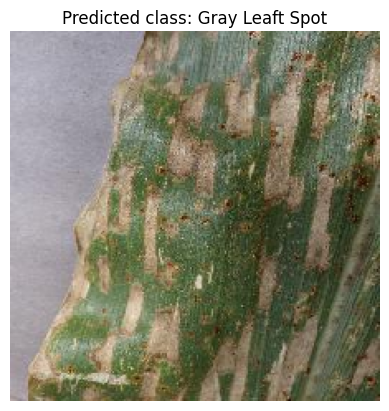

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model yang sudah dilatih
model = load_model('model_checkpoint.h5')

# Unggah file gambar
uploaded = files.upload()

for filename in uploaded.keys():
    # Muat gambar
    img = load_img(filename, target_size=(224, 224))  # Sesuaikan target_size dengan ukuran input model Anda
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch size di awal
    img_array /= 255.0  # Normalisasi gambar

    # Buat prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Tampilkan hasil prediksi
    class_labels = ['Healty', 'Gray Leaft Spot', 'Common Rust', 'Blight']  # Ganti dengan label kelas Anda
    print(f'Predicted class for {filename}: {class_labels[predicted_class[0]]}')

    # Tampilkan gambar
    plt.imshow(img)
    plt.title(f'Predicted class: {class_labels[predicted_class[0]]}')
    plt.axis('off')
    plt.show()
